Demonstrate the use of a densely connected neural network, like the one we trained on the MNIST data set, for classifying stars in the M4 cluster using Gaia's measurements of stars' locations on the sky (right ascension and declination).  This is basically a repeat of what we covered in class, but this time I want you to even out the training set to include roughly equal numbers of M4 members and non-members.

In [1]:
import pandas as pd
import numpy as np

In [2]:
#loaing M4 cluster 
m4_df = pd.read_fwf('../data/NGC6121-1.dat', names=['source_id', 'ra', 'dec', 'phot_g_mean_mag'])
m4_df

,source_id,ra,dec,phot_g_mean_mag
0,6045504229661220736,245.99162,-26.34434,18.438
1,6045504981264184192,246.03035,-26.28057,18.769
2,6045508902585952640,245.88761,-26.24297,19.072
3,6045507180287440000,245.85343,-26.28453,18.495
4,6045503473747038464,245.87124,-26.34628,17.163
...,...,...,...,...
19503,6045337962873610240,245.13976,-27.09970,19.705
19504,6045298891556291712,245.48339,-27.19208,19.493
19505,6045305866578950784,245.69445,-27.06942,18.290
19506,6045303774938119808,245.80824,-27.07275,19.267


In [3]:
#M4 cluster using Gaia's measurements of stars' locations on the sky
#3 degree x 3 degree box centered at `RA=246, dec=-26.5`
df = pd.read_csv('../data/m4_gaia_source.csv')

In [4]:
#classifying cluster members only
m4_sel = df['source_id'].isin(m4_df.source_id)
print(np.count_nonzero(m4_sel))

19084


In [5]:
#checking parameters inside the data
df.columns

Index(['designation', 'source_id', 'ra', 'dec', 'parallax', 'parallax_error',
       'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'astrometric_n_good_obs_al', 'astrometric_chi2_al',
       'visibility_periods_used', 'phot_g_mean_flux_over_error',
       'phot_g_mean_mag', 'phot_bp_mean_flux_over_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag',
       'phot_bp_rp_excess_factor', 'bp_rp', 'radial_velocity',
       'radial_velocity_error'],
      dtype='object')

In [6]:
#location right ascension and declination
params = ['ra', 'dec']
X = np.array(df[params])
X.shape

(494996, 2)

In [7]:
np.count_nonzero(np.any(np.isnan(X), axis=1)) #checking for missing values

0

In [8]:
#when we start adding more columns we might miss values
# If there _were_ missing values, we would remove them like so
nans = np.any(np.isnan(X), axis=1)
X = X[~nans]

n_classes = 2
y = m4_sel.astype(int)[~nans] 

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
#standarizing data
transformer = StandardScaler()

X = transformer.fit_transform(X)

In [11]:
#using 50% data for testing and rest of them for training
m = X.shape[0]
test_frac = 0.5
test_sel = np.random.choice([True, False], size=m, p=[test_frac, 1-test_frac])
X_tst = X[test_sel]
X_train = X[~test_sel]

y_tst = y[test_sel]
y_train = y[~test_sel]

In [12]:
import jax
import jax.numpy as jnp

In [13]:
X_train = jnp.array(X_train)
X_tst = jnp.array(X_tst)
y_train = jnp.array(y_train)
y_tst = jnp.array(y_tst)

In [14]:
#neural network design
batch_size = 64
n_batches = X_train.shape[0] // batch_size

X_train = X_train[:n_batches * batch_size].reshape((n_batches, batch_size, *X_train.shape[1:]))
y_train = y_train[:n_batches * batch_size].reshape((n_batches, batch_size, *y_train.shape[1:]))
X_train.shape, y_train.shape

((3875, 64, 2), (3875, 64))

In [15]:
from flax import linen as nn

In [16]:
#model training
n_classes = 2

class DenseClassifier(nn.Module):
    """A simple dense classifier."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(n_classes)(x)
        return x

In [17]:
#summary of the model
dummy_input = jnp.ones((1, 2))
dnn = DenseClassifier()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                            DenseClassifier Summary                             
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module          ┃ inputs        ┃ outputs       ┃ params           ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│         │ DenseClassifier │ float32[1,2]  │ float32[1,2]  │                  │
├─────────┼─────────────────┼───────────────┼───────────────┼──────────────────┤
│ Dense_0 │ Dense           │ float32[1,2]  │ float32[1,10] │ bias:            │
│         │                 │               │               │ float32[10]      │
│         │                 │               │               │ kernel:          │
│         │                 │               │               │ float32[2,10]    │
│         │                 │               │               │                  │
│         │                 │               │               │ 30 (120 B)       │
├─────────┼────────────────

In [18]:
X_train.shape, y_train.shape

((3875, 64, 2), (3875, 64))

In [19]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [20]:
#we have 162 trainable parameter
#Training

@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

In [21]:
def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

In [22]:
@jax.jit
def train_step(state, batch, label):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [23]:
@jax.jit
def compute_metrics(*, state, batch, label):
    logits = state.apply_fn({'params': state.params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=label, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [24]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01

state = create_train_state(dnn, init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [25]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [26]:
n_epochs = 50

In [27]:
step = 0

for _ in range(n_epochs):
  for batch, label in zip(X_train, y_train):

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, batch, label) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, batch=batch, label=label) # aggregate batch metrics

    if (step+1) % n_batches == 0: # one training epoch has passed
      for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
      state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

      # Compute metrics on the test set after each training epoch
      test_state = state
      test_state = compute_metrics(state=test_state, batch=X_tst, label=y_tst)

      for metric,value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

      print(f"train epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
      print(f"test epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
    step += 1

train epoch: 1, loss: 0.07771429419517517, accuracy: 96.12943267822266
test epoch: 1, loss: 0.1661558300256729, accuracy: 96.18527221679688
train epoch: 2, loss: 0.07710657268762589, accuracy: 96.15040588378906
test epoch: 2, loss: 0.11695696413516998, accuracy: 96.18527221679688
train epoch: 3, loss: 0.07706952840089798, accuracy: 96.14959716796875
test epoch: 3, loss: 0.09752854704856873, accuracy: 96.18527221679688
train epoch: 4, loss: 0.07703060656785965, accuracy: 96.14112854003906
test epoch: 4, loss: 0.08922918885946274, accuracy: 96.18527221679688
train epoch: 5, loss: 0.0770040974020958, accuracy: 96.15282440185547
test epoch: 5, loss: 0.08522786945104599, accuracy: 96.18527221679688
train epoch: 6, loss: 0.07695633918046951, accuracy: 96.15483856201172
test epoch: 6, loss: 0.08267949521541595, accuracy: 96.18527221679688
train epoch: 7, loss: 0.07695695757865906, accuracy: 96.15040588378906
test epoch: 7, loss: 0.12041488289833069, accuracy: 96.18527221679688
train epoch: 8,

In [1]:
import matplotlib.pyplot as plt

NameError: name 'metrics_history' is not defined

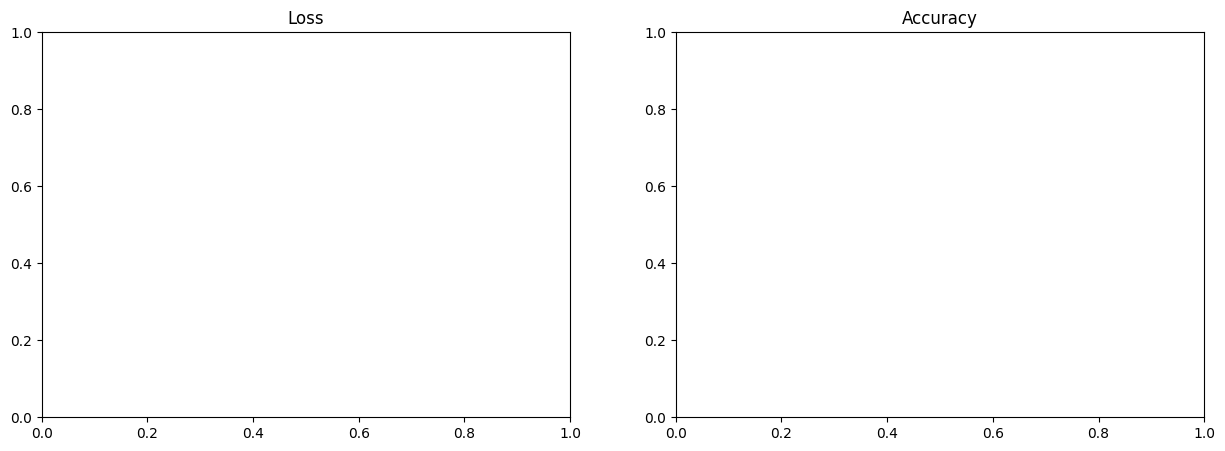

In [2]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [30]:
#checking classifier
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, batch)
  return logits.argmax(axis=1)

pred = pred_step(state, X_tst)
pred

Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

(array([     0.,      0.,      0.,      0.,      0., 246964.,      0.,
             0.,      0.,      0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

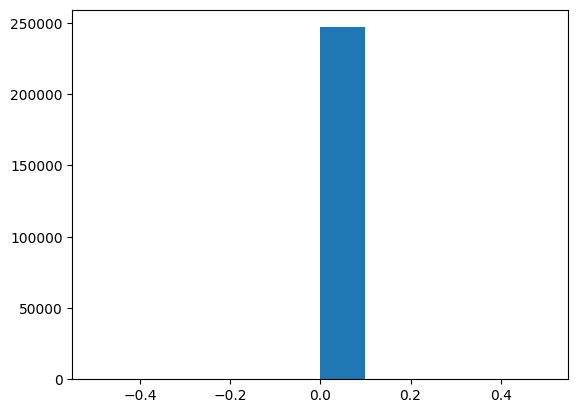

In [31]:
plt.hist(pred)

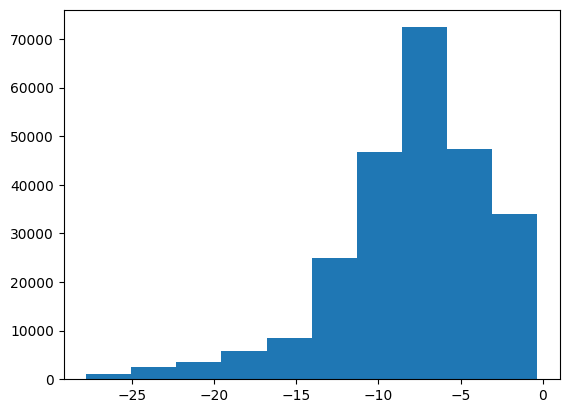

In [32]:
#difference (remember these are "log"its) of the values from the output nodes to see 
# if it's picking up hints of something useful
outputs = state.apply_fn({'params': state.params}, X_tst)
plt.hist(jnp.diff(outputs, axis=1).flatten());

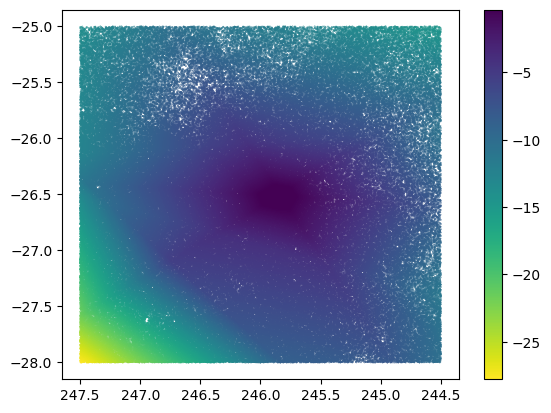

In [33]:
plt.scatter(df.ra[~nans][test_sel], df.dec[~nans][test_sel], c=jnp.diff(outputs, axis=1), s=.1, cmap='viridis_r')
plt.colorbar()

plt.gca().invert_xaxis()

Graduate Part

In [34]:
#location right ascension and declination
params_new = ['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'radial_velocity', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp']
X_new = np.array(df[params_new])
X_new.shape

(494996, 10)

In [35]:
np.count_nonzero(np.any(np.isnan(X_new), axis=1))

487760

In [36]:
nans = np.any(np.isnan(X_new), axis=1)
X_new = X_new[~nans]

n_classes_new = 10
y_new = m4_sel.astype(int)[~nans]

In [37]:
transformer = StandardScaler()

X_new = transformer.fit_transform(X_new)

In [38]:
m = X_new.shape[0]
test_frac_new = 0.5
test_sel_new = np.random.choice([True, False], size=m, p=[test_frac_new, 1-test_frac_new])
X_tst_new = X_new[test_sel_new]
X_train_new = X_new[~test_sel_new]

y_tst_new = y_new[test_sel_new]
y_train_new = y_new[~test_sel_new]

In [39]:
X_train_new = jnp.array(X_train_new)
X_tst_new = jnp.array(X_tst_new)
y_train_new = jnp.array(y_train_new)
y_tst_new = jnp.array(y_tst_new)

In [40]:
#define model
batch_size = 64
n_batches_new = X_train_new.shape[0] // batch_size

X_train_new = X_train_new[:n_batches_new * batch_size].reshape((n_batches_new, batch_size, *X_train_new.shape[1:]))
y_train_new = y_train_new[:n_batches_new * batch_size].reshape((n_batches_new, batch_size, *y_train_new.shape[1:]))
X_train_new.shape, y_train_new.shape

((55, 64, 10), (55, 64))

In [41]:
n_classes_new = 10 #number of features is 10

class DenseClassifier(nn.Module):
    """A simple dense classifier."""

    @nn.compact
    def __call__(self, x_new):
        x_new = nn.Dense(10)(x_new)
        x_new = nn.relu(x_new)
        x_new = nn.Dense(10)(x_new)
        x_new = nn.relu(x_new)
        x_new = nn.Dense(n_classes)(x_new)
        return x_new

In [42]:
dummy_input = jnp.ones((1, 2))
dnn = DenseClassifier()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                            DenseClassifier Summary                             
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module          ┃ inputs        ┃ outputs       ┃ params           ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│         │ DenseClassifier │ float32[1,2]  │ float32[1,2]  │                  │
├─────────┼─────────────────┼───────────────┼───────────────┼──────────────────┤
│ Dense_0 │ Dense           │ float32[1,2]  │ float32[1,10] │ bias:            │
│         │                 │               │               │ float32[10]      │
│         │                 │               │               │ kernel:          │
│         │                 │               │               │ float32[2,10]    │
│         │                 │               │               │                  │
│         │                 │               │               │ 30 (120 B)       │
├─────────┼────────────────

In [43]:
X_train_new.shape, y_train_new.shape

((55, 64, 10), (55, 64))

In [44]:
#we have 250 trainable parameters
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

In [45]:
def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input)['params']
    tx_new = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params_new, tx=tx_new,
        metrics=Metrics.empty())

In [46]:
#training step function
@jax.jit
def train_step(state_new, batch, label):
  """Train for a single step."""
  def loss_fn(params_new):
    logits = state_new.apply_fn({'params_new': params_new}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state_new.params_new)
  state_new = state_new.apply_gradients(grads=grads)
  return state_new

In [47]:
@jax.jit
def compute_metrics(*, state_new, batch, label):
    logits = state_new.apply_fn({'params_new': state_new.params_new}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    metric_updates = state_new.metrics.single_from_model_output(
        logits=logits, labels=label, loss=loss)
    metrics = state_new.metrics.merge(metric_updates)
    state_new = state_new.replace(metrics=metrics)
    return state_new

In [48]:
#initialize model & training state

init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01

state_new = create_train_state(dnn, init_rng, learning_rate)
del init_rng  # Must not be used anymore.

TypeError: Cannot determine dtype of ra

In [ ]:
metrics_history_new = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [ ]:
n_epochs = 50

In [ ]:
step = 0

for _ in range(n_epochs):
  for batch_new, label_new in zip(X_train_new, y_train_new):

    # Run optimization steps over training batches and compute batch metrics
    state_new = train_step(state_new, batch_new, label_new) # get updated train state (which contains the updated parameters)
    state_new = compute_metrics(state_new=state_new, batch_new=batch_new, label_new=label_new) # aggregate batch metrics

    if (step+1) % n_batches == 0: # one training epoch has passed
      for metric_new,value_new in state_new.metrics.compute().items(): # compute metrics
        metrics_history_new[f'train_{metric}'].append(value) # record metrics
      state_new = state_new.replace(metrics=state_new.metrics.empty()) # reset train_metrics for next training epoch

      # Compute metrics on the test set after each training epoch
      test_state_new = state_new
      test_state_new = compute_metrics(state_new=test_state_new, batch=X_tst, label=y_tst)

      for metric,value in test_state_new.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

      print(f"train epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
      print(f"test epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
    step += 1

NameError: name 'state_new' is not defined